<ipython-input-2-afad814893c9>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df.groupby("label", group_keys=False).apply(lambda x: x.sample(frac=train_ratio, random_state=42))
<ipython-input-2-afad814893c9>:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df = remaining_df.groupby("label", group_keys=False).apply(lambda x: x.sample(frac=val_ratio / (val_ratio + test_ratio), random_state=

Epoch 1: Train Loss = 0.5420, Val Loss = 0.5000, Accuracy = 500.0000
Epoch 2: Train Loss = 0.2557, Val Loss = 0.5000, Accuracy = 500.0000
Epoch 3: Train Loss = 0.2609, Val Loss = 0.5000, Accuracy = 500.0000
Epoch 4: Train Loss = 0.2550, Val Loss = 0.5000, Accuracy = 500.0000
Epoch 5: Train Loss = 0.2631, Val Loss = 0.5000, Accuracy = 500.0000
Epoch 6: Train Loss = 0.2572, Val Loss = 0.5000, Accuracy = 500.0000
Epoch 7: Train Loss = 0.2535, Val Loss = 0.5000, Accuracy = 500.0000
Epoch 8: Train Loss = 0.2592, Val Loss = 0.5000, Accuracy = 500.0000
Epoch 9: Train Loss = 0.2535, Val Loss = 0.5000, Accuracy = 500.0000
Epoch 10: Train Loss = 0.2639, Val Loss = 0.5000, Accuracy = 500.0000
Final Test Results - Accuracy: 500.0000, Precision: 0.0590, Recall: 0.5000, F1 Score: 0.1055


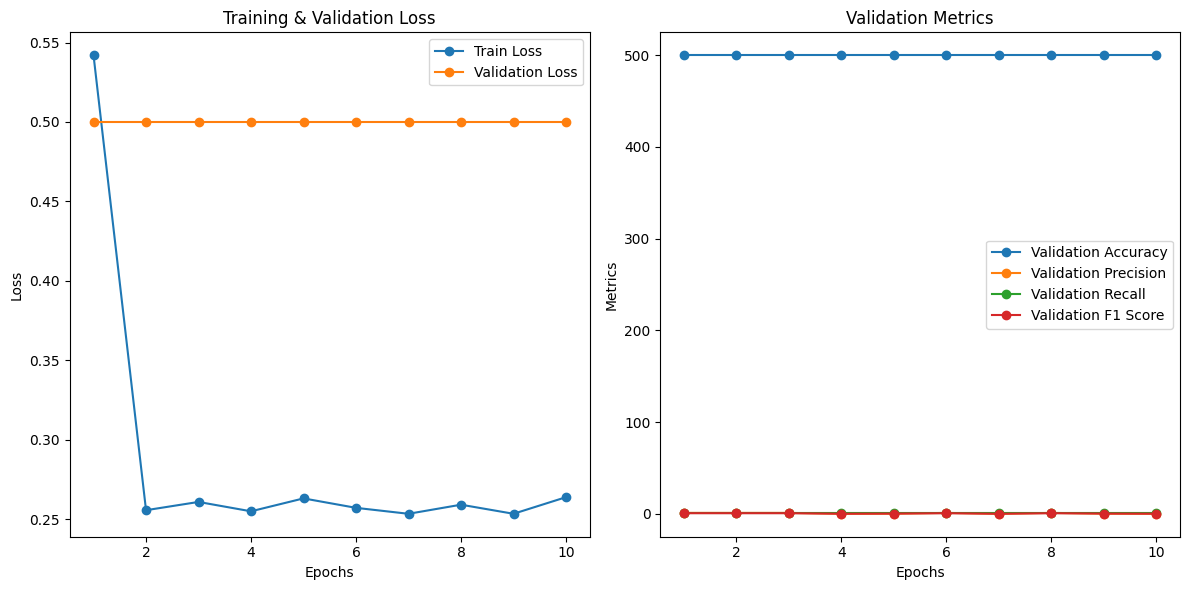

Accuracy: 500.0000, Precision: 0.0470, Recall: 0.5000, F1 Score: 0.0859


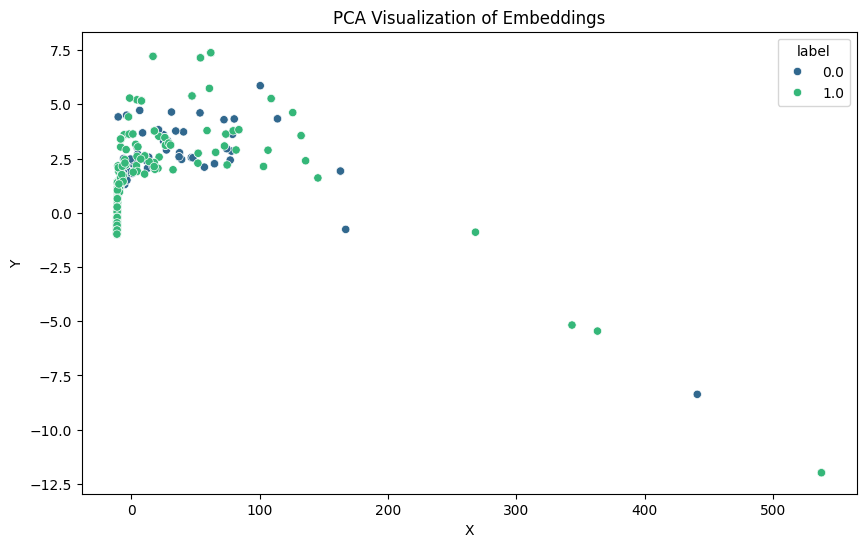

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import numpy as np
from PIL import Image

# data splitting function
def split_data(directory, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    data = []
    for label in os.listdir(directory):
        class_path = os.path.join(directory, label)
        if os.path.isdir(class_path):
            images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            data.extend([(img, label) for img in images])

    df = pd.DataFrame(data, columns=["image_path", "label"])

    # Ensure each class has train/val/test splits
    train_df = df.groupby("label", group_keys=False).apply(lambda x: x.sample(frac=train_ratio, random_state=42))
    remaining_df = df.drop(train_df.index)
    val_df = remaining_df.groupby("label", group_keys=False).apply(lambda x: x.sample(frac=val_ratio / (val_ratio + test_ratio), random_state=42))
    test_df = remaining_df.drop(val_df.index)

    return train_df, val_df, test_df

# datasets (Balanced Pairs)
class SiameseDataset(Dataset):
    def __init__(self, dataframe, transform=None, num_pairs=1000):
        self.transform = transform
        self.num_pairs = min(max(num_pairs, 750), 1500)
        self.label_to_images = dataframe.groupby("label")["image_path"].apply(list).to_dict()
        self.classes = list(self.label_to_images.keys())

        self.pairs = []
        self.labels = []

        # generate 50% similar pairs (label = 0)
        for _ in range(self.num_pairs // 2):
            class_name = random.choice(self.classes)
            img1, img2 = random.sample(self.label_to_images[class_name], 2)
            self.pairs.append((img1, img2))
            self.labels.append(0)

        # Generate 50% dissimilar pairs (label = 1)
        for _ in range(self.num_pairs // 2):
            class1, class2 = random.sample(self.classes, 2)
            img1 = random.choice(self.label_to_images[class1])
            img2 = random.choice(self.label_to_images[class2])
            self.pairs.append((img1, img2))
            self.labels.append(1)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path = self.pairs[idx]
        label = self.labels[idx]

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (img1, img2), torch.tensor(label, dtype=torch.float32)

# transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#ResNet-50 Backbone
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, img1, img2):
        feat1 = self.backbone(img1)
        feat2 = self.backbone(img2)

        combined_features = torch.cat((feat1, feat2), dim=1)

        return self.fc(combined_features)

# loss function: contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, label):
        loss = torch.mean(label * output**2 + (1 - label) * torch.clamp(self.margin - output, min=0.0)**2)
        return loss

# optimizer and scheduler
def initialize_optimizer(model, learning_rate=0.001):
    return optim.Adam(model.parameters(), lr=learning_rate)

def initialize_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

drive_save_path = "/content/drive/MyDrive/model_weight/best_model.pth"

# training Function
def train(model, dataloader, criterion, optimizer, scheduler, device, save_path=drive_save_path):
    model.train()
    total_loss = 0
    best_loss = float('inf')

    for (img1, img2), label in dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(img1, img2)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), save_path)
        # print(f"loss: {best_loss:.4f}")

    return avg_loss

#testing Function
def test(model, dataloader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for (img1, img2), label in dataloader:
            img1, img2 = img1.to(device), img2.to(device)
            output = model(img1, img2)
            preds = (output > 0.5).float().cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(label.cpu().numpy())

    return y_true, y_pred

#evaluation metrics

def custom_accuracy(y_true, y_pred):
    correct = np.sum(np.array(y_true) == np.array(y_pred))
    total = len(y_true)
    return correct / total


def custom_recall(y_true, y_pred):
    TP = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    FN = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 0))
    return TP / (TP + FN) if (TP + FN) > 0 else 0


def custom_precision(y_true, y_pred):
    TP = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    FP = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 1))
    return TP / (TP + FP) if (TP + FP) > 0 else 0


def custom_f1_score(y_true, y_pred):
    precision = custom_precision(y_true, y_pred)
    recall = custom_recall(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


def custom_confusion_matrix(y_true, y_pred):
    TP = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    TN = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 0))
    FP = np.sum((np.array(y_true) == 0) & (np.array(y_pred) == 1))
    FN = np.sum((np.array(y_true) == 1) & (np.array(y_pred) == 0))
    return TP, TN, FP, FN


def evaluate_model(y_true, y_pred):
    acc = custom_accuracy(y_true, y_pred)
    rec = custom_recall(y_true, y_pred)
    prec = custom_precision(y_true, y_pred)
    f1 = custom_f1_score(y_true, y_pred)
    TP, TN, FP, FN = custom_confusion_matrix(y_true, y_pred)

    return acc, rec, prec, f1

# visualizing embeddings
def visualize_embeddings(embeddings, labels, method="pca"):
    if method == "pca":
        reduced = PCA(n_components=2).fit_transform(embeddings)
    else:
        reduced = TSNE(n_components=2).fit_transform(embeddings)

    df = pd.DataFrame(reduced, columns=["X", "Y"])
    df["label"] = labels
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="X", y="Y", hue="label", palette="viridis", data=df)
    plt.title(f"{method.upper()} Visualization of Embeddings")
    plt.show()

# Metrics
def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    # Plot Accuracy, Precision, Recall, F1-score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy", marker='o')
    plt.plot(epochs, history["val_precision"], label="Validation Precision", marker='o')
    plt.plot(epochs, history["val_recall"], label="Validation Recall", marker='o')
    plt.plot(epochs, history["val_f1"], label="Validation F1 Score", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Validation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()


def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for (img1, img2), label in dataloader:
            img1, img2 = img1.to(device), img2.to(device)
            feat1 = model.backbone(img1)
            embeddings.append(feat1.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return np.vstack(embeddings), labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load Data
train_df, val_df, test_df = split_data("/content/drive/MyDrive/caltech-101")

# create datasets and loaders (Balanced)
train_dataset = SiameseDataset(train_df, transform=transform, num_pairs=1000)
val_dataset = SiameseDataset(val_df, transform=transform, num_pairs=1000)
test_dataset = SiameseDataset(test_df, transform=transform, num_pairs=1000)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# model
model = SiameseNetwork().to(device)
optimizer = initialize_optimizer(model)
criterion = ContrastiveLoss()
scheduler = initialize_scheduler(optimizer)

history = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1": []
}

for epoch in range(10):
    train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)

    # Validation step
    y_true, y_pred = test(model, val_loader, device)
    y_true_tensor = torch.tensor(y_true, dtype=torch.float32)
    y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
    val_loss = criterion(y_pred_tensor, y_true_tensor).item()

    acc, prec, rec, f1 = evaluate_model(y_true, y_pred)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Accuracy = {acc:.4f}")

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(acc)
    history["val_precision"].append(prec)
    history["val_recall"].append(rec)
    history["val_f1"].append(f1)

print(f"Final Test Results - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

# Plot Training Metrics
plot_metrics(history)

# Evaluate Model
y_true, y_pred = test(model, test_loader, device)
acc, prec, rec, f1 = evaluate_model(y_true, y_pred)
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

# Extract embeddings and visualize
embeddings, labels = extract_embeddings(model, test_loader, device)
visualize_embeddings(embeddings, labels, method="pca")